In [1]:
import os
os.environ["PINECONE_API_KEY"] = ""
os.environ["GROK_API_KEY"] =""
os.environ["OPENAI_API_KEY"] = ""   
os.environ["LANGSMITH_API_KEY"] = ""
os.environ["LANGSMITH_PROJECT"] = ""

In [38]:
from llama_index.core import VectorStoreIndex, StorageContext, Document, get_response_synthesizer
from llama_index.llms.openai import OpenAI
from llama_index.core.llms import LLMMetadata
from langchain_xai import ChatXAI
from llama_index.core.base.llms.types import MessageRole
from llama_index.vector_stores.pinecone import PineconeVectorStore
from llama_index.embeddings.openai import OpenAIEmbedding
from pinecone import Pinecone, ServerlessSpec
from langchain.tools import tool
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import TypedDict
from langgraph.graph import StateGraph, END
from enum import Enum
from langchain_core.output_parsers import PydanticOutputParser
from IPython.display import display, Markdown
import json

In [3]:
pc = Pinecone()
index_name = "sra-finance-advisor"

if not pc.has_index(index_name):
    print(f"Creating new index '{index_name}' with 1536 dimensions...")
    pc.create_index(
        name=index_name,
        dimension=1536,
        metric="cosine",
        spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1",
        )
    )
pinecone_index = pc.Index(index_name)
index_stats = pc.describe_index(index_name)
pc_index = pc.Index(index_name)

Creating new index 'sra-finance-advisor' with 1536 dimensions...


In [4]:
documents = [
    Document(
        text="Budgeting rule: 50/30/20 - Allocate 50% of your income to needs (essentials like rent and food), 30% to wants (entertainment, dining out), and 20% to savings or debt repayment. This helps build financial stability."
    ),
    Document(
        text="Investing basics for beginners: Start with low-cost index funds or ETFs. Diversify across stocks, bonds, and real estate. Understand risk tolerance: Conservative investors prefer bonds, aggressive ones lean toward stocks. Always research fees and taxes."
    ),
    Document(
        text="Salary budgeting example: For a $50,000 annual salary, after taxes (assume 20% effective rate), take-home is $40,000. Monthly: ~$3,333. Apply 50/30/20: $1,666 needs, $1,000 wants, $667 savings. Track expenses with apps like Mint."
    ),
    Document(
        text="Stock market tips: Invest in blue-chip companies like Apple or Google for stability. Use dollar-cost averaging to buy shares over time. Avoid day trading as a beginner; focus on long-term growth. Monitor via apps like Yahoo Finance."
    ),
    Document(
        text="Crypto risks: High volatility can lead to losses. Only invest what you can afford to lose. Regulations vary by country; in the US, treat as assets for taxes. Diversify with Bitcoin, Ethereum, but beware of scams and hacks."
    ),
]

In [5]:
# Vector Store
embed_model = OpenAIEmbedding()
vector_store = PineconeVectorStore(pinecone_index=pc_index)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

In [6]:
index = VectorStoreIndex.from_documents(
    documents, 
    storage_context=storage_context,
    embed_model=embed_model
)

Upserted vectors: 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]


In [7]:
retriever = index.as_retriever(
    similarity_top_k=2,
    vector_store_query_mode="hybrid",
    alpha=0.5
)

In [8]:
open_ai_llm = OpenAI(
    model="gpt-4o-mini",
)

query_engine = index.as_query_engine(
    vector_store_query_mode="hybrid",
    response_synthesizer=get_response_synthesizer(llm=open_ai_llm)  
)

In [9]:
response1 = query_engine.query("Tell me about investing basics for beginners")
print(response1)

For beginners in investing, it's advisable to start with low-cost index funds or ETFs, which provide a broad market exposure. Diversification is key, so consider spreading investments across various asset classes such as stocks, bonds, and real estate. It's important to understand your risk tolerance; conservative investors typically prefer bonds, while those with a more aggressive stance may favor stocks. Additionally, always be mindful of fees and taxes associated with your investments.


In [10]:
response2 = query_engine.query("50/30/20 budgeting rule for $50K salary")
print(response2)

For a $50,000 annual salary, after accounting for a 20% effective tax rate, the take-home pay would be approximately $40,000. This translates to a monthly income of around $3,333. Following the 50/30/20 budgeting rule, you would allocate approximately $1,666 for needs (essentials), $1,000 for wants (discretionary spending), and $667 for savings or debt repayment each month.


In [26]:
# Prompts
class ResearchOutput(BaseModel):
    answer: str = Field(description="The finance advisor's answer to the query")

class ReflectionOutput(BaseModel):
    score: int = Field(description="Score for response accuracy and completeness (1-10)")
    suggestions: list[str] = Field(description="Suggestions for improvement if score < 8")
    
researcher_prompt = ChatPromptTemplate(
    [
        ("system" ,"You are an researcher with IQ 150, you help people in financial decisions. {format_instructions}"),
        ("human" ,"Give me a good response for this query => {query}, Here is the reference which can help you answer this {reference}")
    ]
)

evaluator_prompt = ChatPromptTemplate(
    [
        ("system" , "You are a good reviewer you give score and suggestions for the query, 1 means worst and 10 means best and suggestions are based on the query to improve the response. {format_instructions}"),
        ("human" ,"This is my response => {response}, for this query => {query}, Give me ranking for this answer btw 1-10")
    ]
)

In [27]:
# Tools
@tool
def retrieve_finance_info(query: str) -> str:
    """ This function retrieves the financial info by using grok llm based on user query """
    try:
        docs = retriever.retrieve(query)
        return "\n".join([doc.text for doc in docs])
    except Exception as e:
        return "Something went wrong while fetching the documents."

In [28]:
groq_llm = ChatXAI(
    model="grok-4-fast-reasoning",
    api_key=os.environ["GROK_API_KEY"],
    temperature=0.7
)

research_parser = PydanticOutputParser(pydantic_object=ResearchOutput)
reflection_parser = PydanticOutputParser(pydantic_object=ReflectionOutput)

research_chain = (
    researcher_prompt 
    | groq_llm 
    | research_parser
)

evaluation_chain = (
    evaluator_prompt 
    | groq_llm 
    | reflection_parser
)

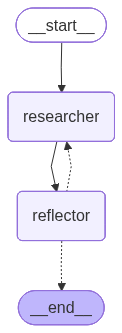

In [40]:
class Status(Enum):
    RESEARCHING = "researching"
    EVALUATING = "evaluating"
    COMPLETED = "completed"
    FAILED = "failed"
    
class AgentState(TypedDict):
    query: str
    response: str
    score : int
    suggestions : list[str]
    iteration : int
    status : Status
    err_msg: str

def should_iterate(state : AgentState)->str:
    if state["status"] == Status.FAILED:
        return "__end__"
    if state["iteration"] == 3:
        return "__end__"
    if state["score"] >=8:
        return "__end__"
    return "researcher"

class ResearcherAgent():
    def process(self, state: AgentState) -> AgentState:
        try: 
            pc_response = retrieve_finance_info.invoke(state["query"])

            research_result = research_chain.invoke({
                    "query": state["query"],
                    "reference": pc_response,
                    "format_instructions": research_parser.get_format_instructions()
                })

            return {
                "query": state["query"],
                "response": research_result.answer,
                "score" : state["score"],
                "suggestions" : [],
                "iteration" : state["iteration"] + 1,
                "status" : Status.RESEARCHING,
                "err_msg" : state["err_msg"]
            }
        except Exception as e:
            return {
                "query": state["query"],
                "response": "Something went wrong while fetching the documents.",
                "score" : 0,
                "suggestions" : [],
                "iteration" : state["iteration"] + 1,
                "status" : Status.FAILED,
                "err_msg" : str(e['error']['message'])
            }

class ReflectorAgent():
    def process(self, state: AgentState) -> AgentState:
        try:
          
            evaluation_result = evaluation_chain.invoke({
                "response": state["response"],
                "query": state["query"],
                "format_instructions": reflection_parser.get_format_instructions()
            })

            return {
                "query": state["query"],
                "response": state["response"],
                "score" : evaluation_result.score,
                "suggestions" : evaluation_result.suggestions,
                "iteration" : state["iteration"],
                "status" : Status.EVALUATING,
                "err_msg" : state["err_msg"]
            }
        except Exception as e:
            return {
                "query": state["query"],
                "response": state["response"],
                "score" : 0,
                "suggestions" : [],
                "iteration" : state["iteration"],
                "status" : Status.FAILED,
                "err_msg" : str(e['error']['message'])
            }

workflow = StateGraph(AgentState)
researcher = ResearcherAgent()
reflector = ReflectorAgent()
workflow.add_node("researcher" , researcher.process)
workflow.add_node("reflector" , reflector.process)
workflow.set_entry_point("researcher")
workflow.add_edge("researcher", "reflector")
workflow.add_conditional_edges("reflector" , should_iterate, {
    "researcher" : "researcher",
    "__end__" : END
})

graph = workflow.compile()
graph

In [41]:

def run_agent_with_markdown_display(query: str):
    """Run the self-reflection agent and display results in markdown format"""
    
    initial_state = {
        "query": query,
        "response": "",
        "score": 0,
        "suggestions": [],
        "iteration": 0,
        "status": Status.RESEARCHING,
        "err_msg": ""
    }
    
    result = graph.invoke(initial_state)
    
    markdown_content = f"""
    ## Self-Reflection Agent Results

    ### Query
    {result['query']}

    ### Final Response
    {result['response']}

    ### 📊 Evaluation Results
    - **Score**: {result['score']}/10
    - **Iterations**: {result['iteration']}
    - **Status**: {result['status'].value}
"""
    
    display(Markdown(markdown_content))

run_agent_with_markdown_display("50/30/20 budgeting rule for $50K salary")


    ## Self-Reflection Agent Results

    ### Query
    50/30/20 budgeting rule for $50K salary

    ### Final Response
    The 50/30/20 budgeting rule is a simple and effective framework for managing your finances, especially on a $50,000 annual salary. It suggests allocating 50% of your after-tax income to needs (essentials like housing, food, utilities, and transportation), 30% to wants (non-essentials like dining out, entertainment, and hobbies), and 20% to savings or debt repayment. This approach promotes financial stability by ensuring you're covering necessities, enjoying life, and building a secure future.

Let's apply this to your $50K salary. Assuming an effective tax rate of about 20% (which can vary by location and deductions), your annual take-home pay would be around $40,000, or approximately $3,333 per month.

- **Needs (50%)**: $1,667/month – Cover must-haves like rent/mortgage (aim for no more than 30% of take-home), groceries, bills, and minimum debt payments.
- **Wants (30%)**: $1,000/month – Budget for fun things like subscriptions, travel, or shopping without guilt.
- **Savings/Debt (20%)**: $667/month – Prioritize an emergency fund (3-6 months of expenses), retirement contributions (e.g., 401(k)), or extra payments on high-interest debt.

Track your spending with free apps like Mint or YNAB to stay on target. Adjust based on your actual tax situation or cost of living—consult a tax advisor for precision. Starting with this rule can help you gain control and work toward goals like buying a home or retiring comfortably.

    ### 📊 Evaluation Results
    - **Score**: 9/10
    - **Iterations**: 1
    - **Status**: evaluating
